# Imports and setup

In [1]:
# Warning imports
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm


# Model imports
from sklearn import model_selection
from sklearn import metrics
from sklearn import ensemble

In [2]:
SEED = 42
FOLDS = 5

skf = model_selection.StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

In [3]:
# No need to run this cell

!mkdir data
!mv Train.csv Test.csv data
!ls data

Test.csv  Train.csv


# Loading and EDA

In [4]:
path = 'data/'

train = pd.read_csv(f'{path}Train.csv')
test = pd.read_csv(f'{path}Test.csv')
submissions = pd.read_excel('subs/Sample_Submission.xlsx')

#### Creating Numerical and Categorical columns

In [5]:
num_cols = list(train.columns[2:10])
categorical_cols = [i for i in train.drop('class', axis=1).columns if i not in num_cols]

#### Checking target distribution

In [6]:
train['class'].value_counts(normalize=True)

1    0.653166
2    0.346834
Name: class, dtype: float64

- Seems like there is a slight **imbalance** in the data

#### Numerical columns distribution in training and testing sets

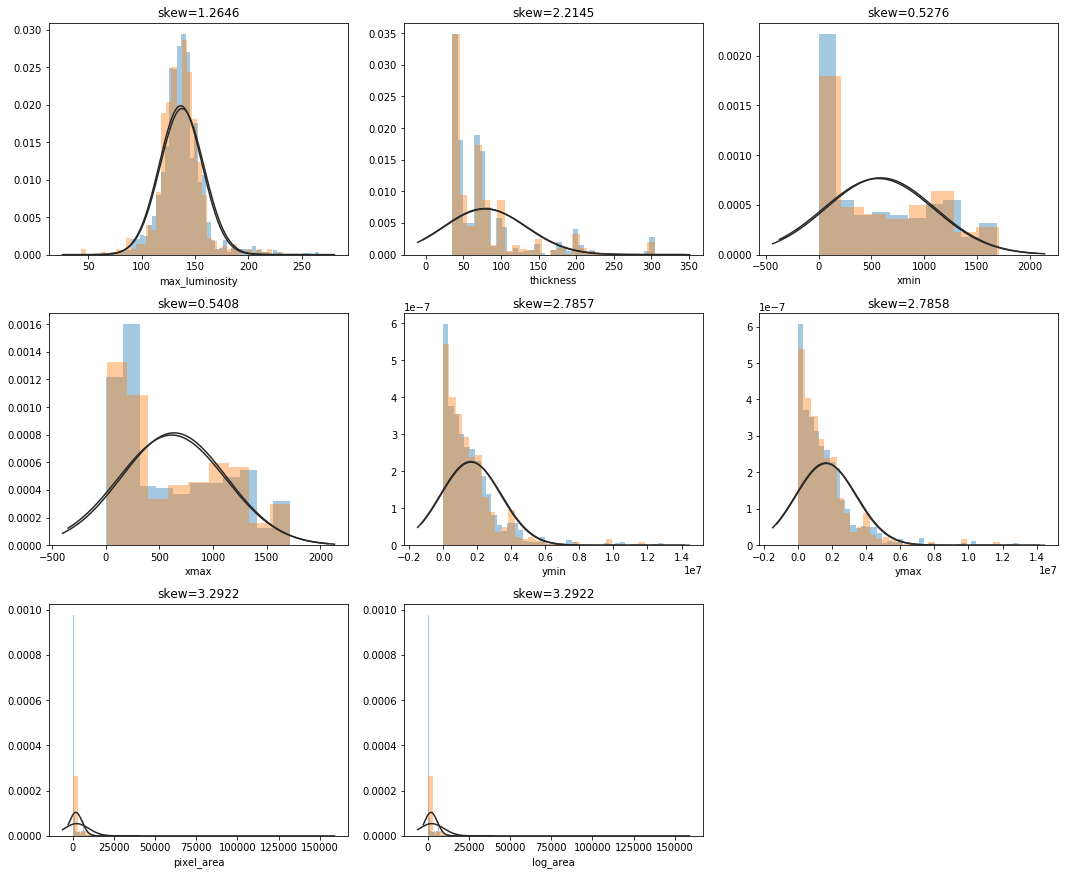

In [7]:
from scipy import stats
from scipy.stats import norm, skew
fcols = 3
frows = len(num_cols)
plt.figure(figsize=(5*fcols,4*frows));

i=0
for col in num_cols:
    i+=1
    ax=plt.subplot(frows,fcols,i);
    sns.distplot(train[col].dropna() , fit=stats.norm, kde=False);
    sns.distplot(test[col].dropna() , fit=stats.norm, kde=False);
    plt.title('skew='+'{:.4f}'.format(stats.skew(train[col])))
    plt.xlabel(col);
plt.tight_layout()

 - Numerical columns seem to be equally distributed among training and testing set.

#### Categorical column distributions in training and testing sets

In [8]:
data = pd.concat([train, test], ignore_index=True)
data['is_train'] = np.where(data['class'].isnull(), 1, 0)

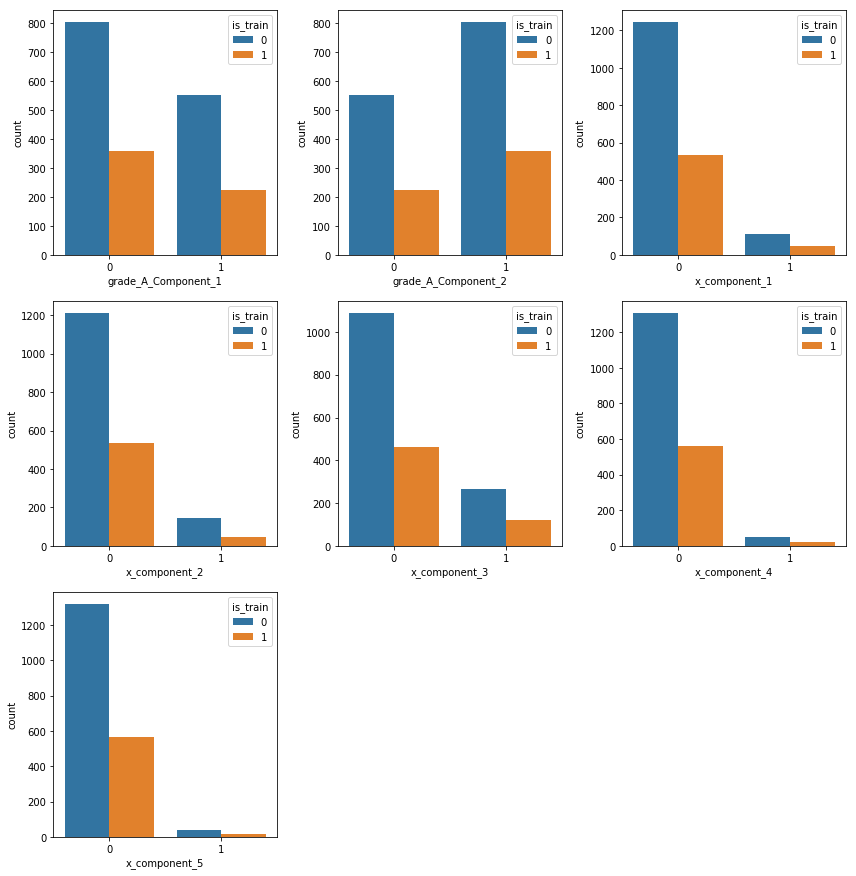

In [9]:
fcols = 3
frows = len(categorical_cols)
plt.figure(figsize=(12,4*frows));

for i,col in enumerate(categorical_cols):
    plt.subplot(frows,fcols,i+1);
    sns.countplot(data[col], hue=data['is_train']);
plt.tight_layout()

- Categorical columns too seem to be equally distributed in training and testing sets
- `x_component_x` columns seem to have very low instances in positive class

#### Relationship between independant categorical and target variable

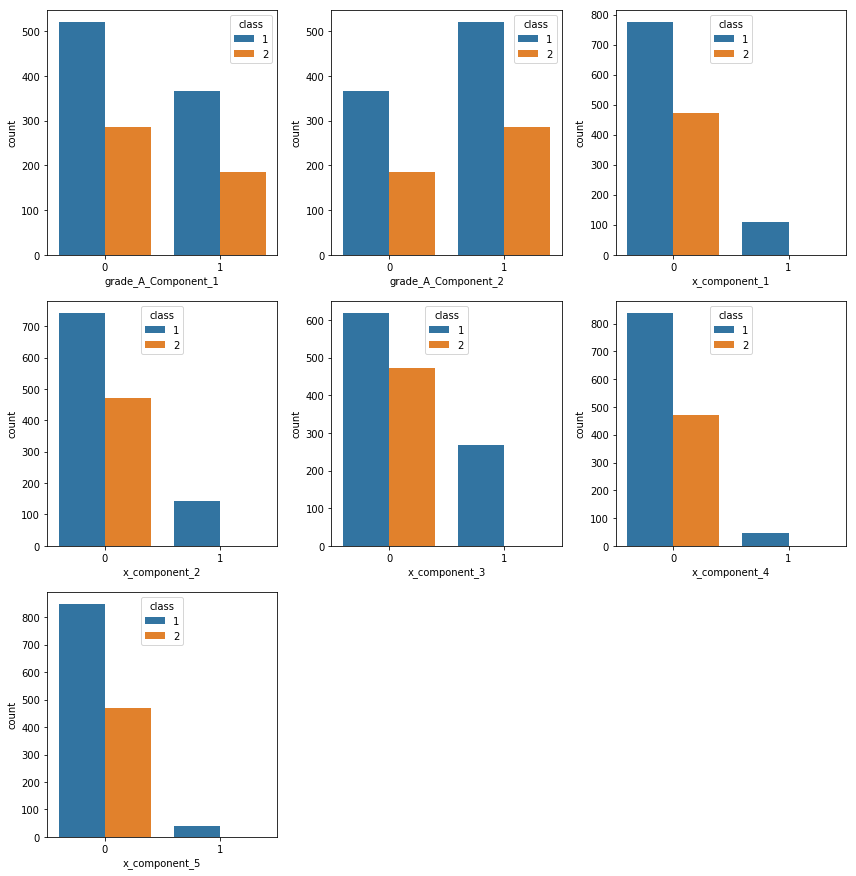

In [10]:
fcols = 3
frows = len(categorical_cols)
plt.figure(figsize=(12,4*frows));

for i,col in enumerate(categorical_cols):
    plt.subplot(frows,fcols,i+1);
    sns.countplot(train[col], hue=train['class']);
plt.tight_layout()

- Well, it seems like we found a **RULE**, wherever `x_component_x` == 1, `class` is always == 1
- Also during EDA it was observed that `grade_A_component_x` and `x_component_x` columns were one-hot encoded

# Model Building and Evaluation

In [15]:
X = train.drop('class', axis=1)
y = train['class'].values
Xt = test.copy()

#### Reverse the one-hot encoding on `x_compnent_x` columns and convert it into ordinals

In [16]:
def reverse_ohe(row):
    for c in x_component:
        if row[c]==1:
            return c

        
x_component = ['x_component_1', 'x_component_2', 'x_component_3', 'x_component_4', 'x_component_5']

X['x_component'] = X[x_component].apply(reverse_ohe, axis=1)
Xt['x_component'] = Xt[x_component].apply(reverse_ohe, axis=1)

In [17]:
x_mapper = {'None' : 0, 'x_component_1' : 1, 'x_component_2' : 2,'x_component_3' : 3, 'x_component_4' : 4, 'x_component_5' : 5}

In [18]:
X['x_component'] = X['x_component'].map(x_mapper).fillna(0).astype('int')
Xt['x_component'] = Xt['x_component'].map(x_mapper).fillna(0).astype('int')

#### Frequency encoding `x_component` column

In [19]:
def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

for column in ['x_component', 'grade_A_Component_1']:
    train_values, test_values = frequency_encoding(column, X, Xt)
    X[column+'_counts'] = train_values
    Xt[column+'_counts'] = test_values

In [20]:
X.drop(['grade_A_Component_1', 'x_component','pixel_area'], axis=1, inplace=True)
Xt.drop(['grade_A_Component_1', 'x_component','pixel_area'], axis=1, inplace=True)

#### Feature Engineering

In [21]:
X['xmin_sub_xmax'] = abs(X['xmin'] - X['xmax'])
X['thickness_sub_max_luminosity'] = abs(X['thickness'] - X['max_luminosity'])

X['thickness_div_max_luminosity'] = X['thickness'] / X['max_luminosity']
X['xmin_div_xmax'] = X['xmin'] / X['xmax']
X['xmax_div_thickness'] = X['xmax'] / X['thickness']
X['ymin_div_thickness'] = X['ymin'] / X['thickness']

X['max_luminosity_mul_thickness'] = X['max_luminosity'] * X['thickness']
X['xmax_mul_thickness'] = X['xmax'] * X['thickness']
X['ymin_mul_thickness'] = X['ymin'] * X['thickness']
X['ymax_mul_thickness'] = X['ymax'] * X['thickness']
X['logarea_mul_thickness'] = X['log_area'] * X['thickness']



Xt['xmin_sub_xmax'] = abs(Xt['xmin'] - Xt['xmax'])
Xt['thickness_sub_max_luminosity'] = abs(Xt['thickness'] - Xt['max_luminosity'])

Xt['thickness_div_max_luminosity'] = Xt['thickness'] / Xt['max_luminosity']
Xt['xmin_div_xmax'] = Xt['xmin'] / Xt['xmax']
Xt['xmax_div_thickness'] = Xt['xmax'] / Xt['thickness']
Xt['ymin_div_thickness'] = Xt['ymin'] / Xt['thickness']

Xt['max_luminosity_mul_thickness'] = Xt['max_luminosity'] * Xt['thickness']
Xt['xmax_mul_thickness'] = Xt['xmax'] * Xt['thickness']
Xt['ymin_mul_thickness'] = Xt['ymin'] * Xt['thickness']
Xt['ymax_mul_thickness'] = Xt['ymax'] * Xt['thickness']
Xt['logarea_mul_thickness'] = Xt['log_area'] * Xt['thickness']

In [22]:
X.shape, Xt.shape

((1358, 26), (583, 26))

#### Training the classifier

In [27]:
%%time

logloss = list()
oof_etc = np.zeros((len(X),2))
cv_test_preds_etc = np.zeros((len(Xt),2))

for train_idx, test_idx in skf.split(X, y):
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_test, y_test = X.iloc[test_idx, :], y[test_idx]
    
    etc = ensemble.ExtraTreesClassifier(n_estimators=1000, random_state=SEED, class_weight='balanced')
    etc.fit(X_train, y_train)
    
    preds = etc.predict_proba(X_test)
    oof_etc[test_idx] = preds
    
#   CV test prediction
    cv_test_preds_etc += etc.predict_proba(Xt) / FOLDS
    
    
    logloss = np.append(logloss, metrics.log_loss(y_true=y_test, y_pred=preds))
    
print(f'Mean CV log loss: {np.mean(logloss):.4f} and std Dev. is {np.std(logloss):.2f} \n')

Mean CV log loss: 0.2617 and std Dev. is 0.02 

CPU times: user 12.9 s, sys: 222 ms, total: 13.1 s
Wall time: 13.5 s


#### Use the rule found during EDA on train and test columns

In [28]:
oof_etc = pd.DataFrame(oof_etc, columns=['1','2'])

train_preds = pd.concat([train, oof_etc], axis=1)
train_preds['x_component'] = train_preds['x_component_1'] + train_preds['x_component_2'] + train_preds['x_component_3'] + train_preds['x_component_4'] + train_preds['x_component_5']

train_preds.loc[train_preds['x_component'] == 1, '1'] = 1.0
train_preds.loc[train_preds['x_component'] == 1, '2'] = 0.0

Lloss = metrics.log_loss(train_preds['class'], train_preds[['1','2']])
print(f'Log Loss: {Lloss:.4f}')

Log Loss: 0.2601


In [25]:
cv_test_preds_etc = pd.DataFrame(cv_test_preds_etc, columns=['1','2'])
test_preds = pd.concat([test, cv_test_preds_etc], axis=1)

test_preds['x_component'] = test_preds['x_component_1'] + test_preds['x_component_2'] + test_preds['x_component_3'] + test_preds['x_component_4'] + test_preds['x_component_5']

test_preds.loc[test_preds['x_component'] == 1, '1'] = 1.0
test_preds.loc[test_preds['x_component'] == 1, '2'] = 0.0

# Create submission file

In [26]:
SUB_FILE_NAME = 'etc_fe.xlsx'
sample_sub = test_preds[['1','2']]
sample_sub.to_excel(SUB_FILE_NAME, index=False)

def create_download_link(title = "Download EXCEL file", filename = "data.xlsx"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)


create_download_link(filename = SUB_FILE_NAME)